In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Ruta de la carpeta principal que contiene los datos
folder_path = '/content/drive/MyDrive/TFM/UJI_LIB_DB_v2.2/db/'

meses = ["01", "02"]#, "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25"]

trn_01 = ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15"]
trn_25 = ["02"]
tst = ["02", "03", "04", "05"]

df_i = pd.DataFrame()
df_o = pd.DataFrame()
t_df_i = pd.DataFrame()
t_df_o = pd.DataFrame()

for session in meses:


  # Train
  file_path = folder_path + session +  "/" + "trn01rss.csv"
  df_i = pd.concat([df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

  file_path = folder_path + session +  "/" + "trn01crd.csv"
  df_o = pd.concat([df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

  if session  == "01":
    for rep in trn_01:

      file_path = folder_path + session +  "/" + "trn" + rep + "rss.csv"
      df_i = pd.concat([df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

      file_path = folder_path + session +  "/"+ "trn" + rep + "crd.csv"
      df_o = pd.concat([df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

  # Test
  file_path = folder_path + session +  "/"+ "tst01rss.csv"
  t_df_i = pd.concat([t_df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

  file_path =folder_path + session +  "/"+"tst01crd.csv"
  t_df_o = pd.concat([t_df_o, pd.read_csv(file_path, header=None)], ignore_index=True)

  for rep in tst:

    file_path = folder_path + session +  "/" + "tst"+ rep +"rss.csv"
    t_df_i = pd.concat([t_df_i, pd.read_csv(file_path, header=None)], ignore_index=True)

    file_path =folder_path + session +  "/" + "tst"+ rep +"crd.csv"
    t_df_o = pd.concat([t_df_o, pd.read_csv(file_path, header=None)], ignore_index=True)



# Cambia los valores de la planta por metros. La planta 3 será 0 metros, la planta 5 serán 3.7 metros
df_o.iloc[:, 2] = df_o.iloc[:, 2].replace({3: 0, 5: 3.7})
# Igual para el de test
t_df_o.iloc[:, 2] = t_df_o.iloc[:, 2].replace({3: 0, 5: 3.7})





--------------------------------------------------------------------------------
**Limpieza de datos**
--------------------------------------------------------------------------------



In [ ]:
def analyze_potential_active_aps(df, umbral):
    missing_counts = (df == 100).sum()
    total_measurements = df.shape[0]
    active_aps = {}
    for ap, missing_count in missing_counts.items():
        proportion = 1 - (missing_count / total_measurements)  # Proporción de mediciones con detección
        if proportion > umbral:  # Si la proporción de mediciones con detección es mayor al umbral%, considerarlo activo
            active_aps[ap] = proportion

    active_aps_df = pd.DataFrame.from_dict(active_aps, orient='index', columns=['Proporción de Mediciones con Detección'])
    active_aps_df.index.name = 'Punto de Acceso'


    return active_aps

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go

def knn_colums(df_i, proportion):
  active_aps = list(analyze_potential_active_aps(df_i, umbral))
  df_i_active_aps = df_i.iloc[:,active_aps]
  t_df_i_active_aps = t_df_i.iloc[:, active_aps]

  num_vecinos = 3 # Para probar otras opciones

  knn = NearestNeighbors(n_neighbors=num_vecinos)
  knn.fit(df_i_active_aps, df_o)
  distances_active, indices_active = knn.kneighbors(t_df_i_active_aps)


  knn_df_o_errors=[]


  for i in range(len(t_df_i_active_aps)):
      knn_df_o = df_o.iloc[indices_active[i],:].mean(axis=0)
      distancia_euclidea = np.linalg.norm(t_df_o.iloc[i,:].values - knn_df_o.values)

      knn_df_o_errors.append(distancia_euclidea)

  media_active_ap = np.mean(knn_df_o_errors)
  desviacion_estandar_active_ap = np.std(knn_df_o_errors)
  minimo_active_ap = np.min(knn_df_o_errors)
  maximo_active_ap = np.max(knn_df_o_errors)


  print("\n")
  print("\n")

  return media_active_ap

















































[2.7616296468494093, 2.7526112954675996, 2.756833921278934, 2.756550078758465, 2.7515759624727005, 2.734447543755718, 2.734447543755718, 2.7268829047220677, 2.7338516017111827, 2.73624479451397, 2.7365204866171577, 2.742946216015467]


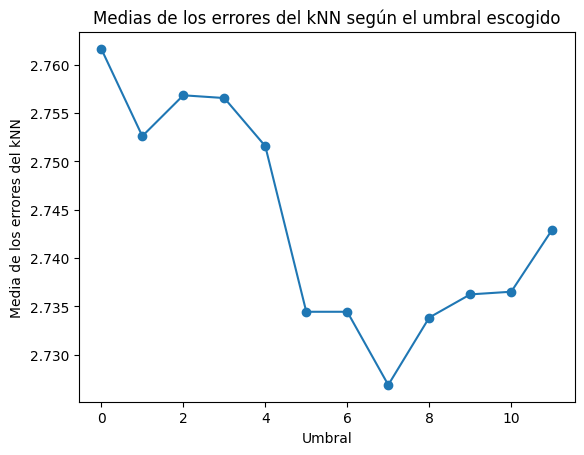

In [ ]:
import matplotlib.pyplot as plt

umbrales = np.arange(0, 0.06, 0.005)


media_active_ap_vector = []

for umbral in umbrales:
  media_active_ap = knn_colums(df_i, umbral)
  media_active_ap_vector.append(media_active_ap)


print(media_active_ap_vector)

plt.plot(media_active_ap_vector, '-o')
# Añadir etiquetas al eje x y al eje y
plt.xlabel('Umbral')
plt.ylabel('Media de los errores del kNN')

# Añadir título a la gráfica
plt.title('Medias de los errores del kNN según el umbral escogido')

# Mostrar la gráfica
plt.show()

In [ ]:
print("Entonces, ¿cual es el menor umbral?")
umbral_definitivo = umbrales[media_active_ap_vector.index(min(media_active_ap_vector))]
print(umbral_definitivo)

Entonces, ¿cual es el menor umbral?
0.035


In [ ]:
print("Entonces, nos quedamos con el df_i y t_df_i que cumple con que los PA definidos en esta base de datos tienen detecciones al menos un ", umbral * 100, "% de las veces")
active_aps_final = list(analyze_potential_active_aps(df_i, umbral_definitivo))
X_train = df_i.iloc[:,active_aps_final]
X_test = t_df_i.iloc[:,active_aps_final]
y_train = df_o
y_test = t_df_o


#como log, necesito saber el número de PA que estamos considerando
print("Número de PA que estamos considerando: ", len(X_train.iloc[0,:]))

Entonces, nos quedamos con el df_i y t_df_i que cumple con que los PA definidos en esta base de datos tienen detecciones al menos un  5.5 % de las vece
Número de PA que estamos considerando:  67


--------------------------------------------------------------------------------

**MLP**

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
import time

mlp = MultiOutputRegressor(MLPRegressor(learning_rate='constant', learning_rate_init=0.01, hidden_layer_sizes=(500,), max_iter=5000, warm_start=True)) #cambio max_iter pq dice que no converge
batch_size = 10
n_batches = len(X_train) // batch_size

start_train = time.time()

# Entrenamiento incremental por lotes
for i in range(n_batches):
    X_batch = X_train[i * batch_size:(i + 1) * batch_size]
    y_batch = y_train[i * batch_size:(i + 1) * batch_size]
    mlp.partial_fit(X_batch, y_batch)

if len(X_train) % batch_size != 0:
    X_batch = X_train[n_batches * batch_size:]
    y_batch = y_train[n_batches * batch_size:]
    mlp.partial_fit(X_batch, y_batch)

end_train = time.time()

start_pred = time.time()
predictions = mlp.predict(X_test)
end_pred = time.time()


print(predictions[0,:])
print(y_test.iloc[0,:])

errores = []

# Calcular errores individuales
for i in range(len(X_test)):
    error_i = y_test.iloc[i, :].values - predictions[i]
    distancia_euclidea = np.linalg.norm(error_i)
    errores.append(distancia_euclidea)

# Calcular estadísticas de error
media_mlp = np.mean(errores)
desviacion_estandar_mlp = np.std(errores)
minimo_mlp = np.min(errores)
maximo_mlp = np.max(errores)
tiempo_entrenamiento_mlp = end_train - start_train
tiempo_prediccion_mlp = end_pred - start_pred

# Imprimir resultados
print("Visión general del rendimiento y la dispersión de las predicciones del modelo MLP")
print(f"Media: {media_mlp:.2f}")
print(f"Desviación estándar: {desviacion_estandar_mlp:.2f}")
print(f"Mínimo: {minimo_mlp:.2f}")
print(f"Máximo: {maximo_mlp:.2f}")
print(f"Tiempo entrenamiento: {tiempo_entrenamiento_mlp:.2f}")
print(f"Tiempo predicciones: {tiempo_prediccion_mlp:.2f}")


[ 7.69081303 13.42283515  0.02863559]
0    12.913852
1    29.216544
2     0.000000
Name: 0, dtype: float64
Visión general del rendimiento y la dispersión de las predicciones del modelo MLP
Media: 14.00
Desviación estándar: 5.85
Mínimo: 0.30
Máximo: 68.23
Tiempo entrenamiento: 17.42
Tiempo predicciones: 0.10
